# Project 4: "Weather Forecast Post-Processing": Group Project Exercise Sheet

Group 8: Deepak Reddy Chinthaparthy, Khuzaima Aziz, Ali Bagheri ,Muhammad Abdul Wasay Khalid

Gradient Boosting Setup 1 


In [5]:
library(fields)
library(maps)
library(zoo)
library(pls)
library(ggplot2)

getwd()

[1] "/home/sc.uni-leipzig.de/dn020mlae/group_project4"

In [3]:
fcs.test <- readRDS("data/ESSD_benchmark_test_data_forecasts.rds")
fcs.train <- readRDS("data/ESSD_benchmark_training_data_forecasts.rds")
obs.train <- readRDS("data/ESSD_benchmark_training_data_observations.rds")
obs.test <- readRDS("data/ESSD_benchmark_test_data_observations_4students.rds")

In [4]:
## Initialize empty list to store training data for all stations
trai_all <- list()

## Define the lead time you want to use
this_leadtime <- 120

## Function to process training data
process_training_data <- function(obs_data, fcs_data) {
  data_list <- list()
  
  ## Iterate over each year in the dataset
  for (year in unique(fcs_data$year)) {
    ## Get the index for the specified lead time
    idx_lt <- which(obs_data$leadtime == this_leadtime)
    ## Get the index for the current year
    idx_year <- which(obs_data$year == year)
    
    ## Iterate over each station ID
    for (this_station in unique(obs_data$latlon$station.id)) {
      ## Get the index for the current station
      idx_sta <- which(obs_data$latlon$station.id == this_station)
      
      ## Extract the observational data for t2m based on the indices
      obs <- obs_data$data$t2m[idx_lt, idx_year, , idx_sta]
      year_dummy <- as.POSIXct(paste0(2017 - 20 + year, '-01-01'), origin="1970-01-01")
      time <- year_dummy + obs_data$time * 3600 * 24 + this_leadtime * 3600
      fctime_obs_trai <- year_dummy + obs_data$time * 3600 * 24
      
      ## Combine the observation data with time and other attributes
      obs_df <- data.frame(fctime_obs_trai, this_leadtime, this_station, obs)
      colnames(obs_df) <- c('init', 'lt', 'stat', 'obs')
      
      ## Extract the forecast data based on the same indices
      dmo <- fcs_data$data$t2m[idx_lt, idx_year, , idx_sta]
      tp6 <- fcs_data$data$tp6[idx_lt, idx_year, , idx_sta]
      sshf6 <- fcs_data$data$sshf6[idx_lt, idx_year, , idx_sta]
      slhf6 <- fcs_data$data$slhf6[idx_lt, idx_year, , idx_sta]
      ssr6 <- fcs_data$data$ssr6[idx_lt, idx_year, , idx_sta]
      str6 <- fcs_data$data$str6[idx_lt, idx_year, , idx_sta]
      cp6 <- fcs_data$data$cp6[idx_lt, idx_year, , idx_sta]
      mx2t6 <- fcs_data$data$mx2t6[idx_lt, idx_year, , idx_sta]
      mn2t6 <- fcs_data$data$mn2t6[idx_lt, idx_year, , idx_sta]
      ssrd6 <- fcs_data$data$ssrd6[idx_lt, idx_year, , idx_sta]
      strd6 <- fcs_data$data$strd6[idx_lt, idx_year, , idx_sta]
      p10fg6 <- fcs_data$data$p10fg6[idx_lt, idx_year, , idx_sta]
      
      ## Combine the forecast data into one dataframe
      forecast_df <- data.frame(dmo, tp6, sshf6, slhf6, ssr6, str6, cp6, mx2t6, mn2t6, ssrd6, strd6, p10fg6)
      time <- year_dummy + fcs_data$time * 3600 * 24 + this_leadtime * 3600
      
      ## Create a data frame for the combined data
      combined_df <- data.frame(time, obs_df, forecast_df)
      
      ## Append to the appropriate list
      data_list[[paste(year, this_station, sep = "_")]] <- combined_df
    }
  }
  
  return(do.call(rbind, data_list))
}

## Process training data
trai_all <- process_training_data(obs.train, fcs.train)

## Remove row names to avoid 460.1, 460.2 etc.
rownames(trai_all) <- NULL

## Remove any rows with NA values
trai_all <- na.omit(trai_all)

## Filter the training data to only include observations before 2017-01-01 (if needed)
trai_all <- trai_all[which(trai_all$time < as.POSIXct('2017-01-01')),]

## Convert K to °C for training data
convert_to_celsius <- function(data) {
  data$obs <- data$obs - 273.15
  data$dmo <- data$dmo - 273.15
  data$mx2t6 <- data$mx2t6 - 273.15
  data$mn2t6 <- data$mn2t6 - 273.15
  return(data)
}

trai_all <- convert_to_celsius(trai_all)

## Adding sine and cosine for day of the year for train set
add_sin_cos_doy <- function(data) {
  yday <- as.POSIXlt(data$time)$yday
  data$sin.doy <- sin(2 * pi * yday / 365)
  data$cos.doy <- cos(2 * pi * yday / 365)
  return(data)
}

trai_all <- add_sin_cos_doy(trai_all)

## Inspect the resulting data frame
head(trai_all)
str(trai_all)
dim(trai_all)

,time,init,lt,stat,obs,dmo,tp6,sshf6,slhf6,ssr6,str6,cp6,mx2t6,mn2t6,ssrd6,strd6,p10fg6,sin.doy,cos.doy
,<dttm>,<dttm>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1998-01-06,1998-01-01,120,460,-6.5,-11.7586426,0.000000e+00,870224,103072,0,-1514784,0,-11.2161926,-11.780646,0,4053408,6.301232,0.0859648,0.9962982
2,1998-01-09,1998-01-04,120,460,-6.5,-4.6725220,5.722046e-06,1552,-112928,0,57552,0,-4.2342896,-4.715826,0,6446160,5.687511,0.1372788,0.9905325
3,1998-01-13,1998-01-08,120,460,-4.9,-14.0139832,1.576664e-06,559024,68736,0,-1082768,0,-9.8909668,-13.855078,0,4385712,3.995073,0.2051045,0.9787401
4,1998-01-16,1998-01-11,120,460,-1.2,0.5176636,0.000000e+00,1292624,-10656,0,-1336656,0,0.6864258,-1.700659,0,5063936,7.311318,0.2553533,0.9668478
5,1998-01-20,1998-01-15,120,460,2.0,1.7078491,4.005432e-05,317392,60576,0,-111728,0,2.4986511,1.742273,0,6815776,4.784665,0.3212697,0.9469878
6,1998-01-23,1998-01-18,120,460,5.4,1.8503662,0.000000e+00,1131696,-23808,0,-1058768,0,4.1524902,1.886560,0,5820544,8.240839,0.3697245,0.9291414


'data.frame':	188410 obs. of  19 variables:
 $ time   : POSIXct, format: "1998-01-06 00:00:00" "1998-01-09 00:00:00" ...
 $ init   : POSIXct, format: "1998-01-01 00:00:00" "1998-01-04 00:00:00" ...
 $ lt     : num  120 120 120 120 120 120 120 120 120 120 ...
 $ stat   : int  460 460 460 460 460 460 460 460 460 460 ...
 $ obs    : num  -6.5 -6.5 -4.9 -1.2 2 ...
 $ dmo    : num  -11.759 -4.673 -14.014 0.518 1.708 ...
 $ tp6    : num  0.00 5.72e-06 1.58e-06 0.00 4.01e-05 ...
 $ sshf6  : num  870224 1552 559024 1292624 317392 ...
 $ slhf6  : num  103072 -112928 68736 -10656 60576 ...
 $ ssr6   : num  0 0 0 0 0 0 0 0 0 0 ...
 $ str6   : num  -1514784 57552 -1082768 -1336656 -111728 ...
 $ cp6    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ mx2t6  : num  -11.216 -4.234 -9.891 0.686 2.499 ...
 $ mn2t6  : num  -11.78 -4.72 -13.86 -1.7 1.74 ...
 $ ssrd6  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ strd6  : num  4053408 6446160 4385712 5063936 6815776 ...
 $ p10fg6 : num  6.3 5.69 4 7.31 4.78 ...
 $ sin.doy: num  0.

[1] 188410     19

**Example for one station finding out the optimal number of trees using gbm.perf as discussed in class**




[1] "Optimal number of trees: 434"
[1] "MSE: 3.30920550150438"


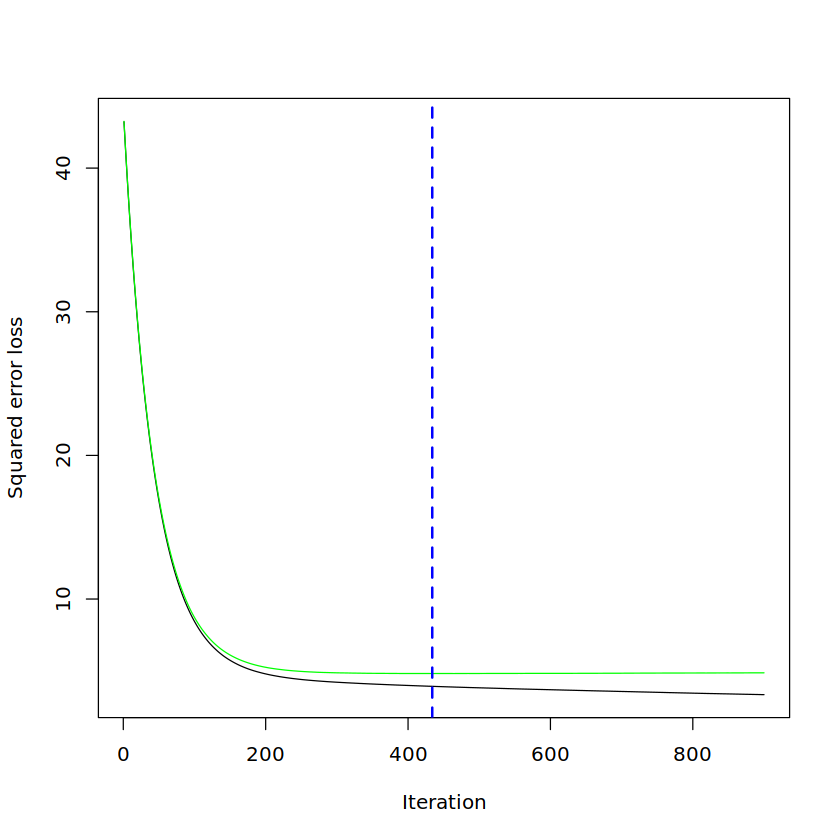

In [23]:
# Example for one station finding out the optimal number of trees using gbm.perf as discussed in class
library(gbm)

# Set a random seed for reproducibility
set.seed(123)

# Train GBM model with cross-validation
gbm_model <- gbm(
  formula = obs ~ dmo + cos.doy + sin.doy + tp6 + sshf6 + slhf6 + ssr6 + str6 + cp6 + mx2t6 + mn2t6 + ssrd6 + strd6 + p10fg6,
  data = trai,
  distribution = "gaussian",  # assuming a regression task
  n.trees = 900,             # number of trees (boosting iterations)
  interaction.depth = 10,    # maximum depth of individual trees
  shrinkage = 0.012,         # learning rate (eta)
  bag.fraction = 0.9,        # fraction of data randomly sampled for each tree
  cv.folds = 5,              # number of cross-validation folds
  verbose = FALSE            # set to TRUE for more verbose output
)

# Determine the optimal number of trees using cross-validation
best_iter <- gbm.perf(gbm_model, method = "cv")

# Print the optimal number of trees
print(paste("Optimal number of trees:", best_iter))



# Make predictions using the optimal number of trees
pred <- predict(gbm_model, newdata = test, n.trees = best_iter)

# Evaluate performance (e.g., MSE)
y_test <- test$obs



na_indices <- which(is.na(y_test))

# Remove NA rows from y_test
y_test <- y_test[-na_indices]
pred <- pred[-na_indices]

# Remove corresponding rows from test
mse <- mean((pred - y_test)^2)
print(paste("MSE:", mse))


# **Typical Grid Parameter Search Used in Our Model**

**Uses this range of values depicted in bracket and finding out the optimal parameter:**

- **n.trees** = 74 (**74, 77, 80**)
- **interaction.depth** = 9 (**3, 6, 9, 12**)
- **shrinkage** = 0.1 (**0.01, 0.05, 0.1**)
- **bag.fraction** = 0.8 (**0.5, 0.7, 0.8, 0.9**)


In [31]:
library(gbm)
set.seed(123)
# Define the target variable
y_trai <- trai$obs
y_test <- test$obs

# Define parameter grid (adjust values and ranges as needed)
param_grid <- expand.grid(
  n.trees = c(74,77,80),        # Number of trees (boosting iterations)
  interaction.depth = c(3, 6, 9,12),      # Maximum depth of individual trees
  shrinkage = c(0.01, 0.05, 0.1),      # Learning rate (eta)
  bag.fraction = c(0.5, 0.7,0.8, 0.9)      # Fraction of data randomly sampled for each tree
)

# Initialize variables to store results
best_rmse <- Inf
best_model <- NULL

# Perform grid search
for (i in 1:nrow(param_grid)) {
  # Train GBM model
  gbm_model <- gbm(
    formula = obs ~ dmo + p10fg6  + str6 + slhf6 + tp6 + cos.doy,
    data = trai,
    distribution = "gaussian",
    n.trees = param_grid$n.trees[i],
    interaction.depth = param_grid$interaction.depth[i],
    shrinkage = param_grid$shrinkage[i],
    bag.fraction = param_grid$bag.fraction[i],
    verbose = FALSE
  )
  
  # Make predictions on test data
  pred <- predict(gbm_model, newdata = test, n.trees = param_grid$n.trees[i])
  
  # Evaluate RMSE
  rmse <- sqrt(mean((pred - y_test)^2, na.rm = TRUE))  # Ensure NA values are handled
  
  # Check for NaN RMSE
  if (is.nan(rmse)) {
    cat("Warning: NaN RMSE encountered for parameters:\n")
    print(param_grid[i, ])
    next  # Skip to next iteration if NaN RMSE occurs
  }
  
  # Print current parameters and RMSE
  cat("Parameters:", paste(names(param_grid)[1:i], param_grid[i, ], sep = " = "), "\n")
  cat("RMSE:", rmse, "\n\n")
  
  # Check if current model is the best so far
  if (rmse < best_rmse) {
    best_rmse <- rmse
    best_model <- gbm_model
  }
}

# Print best RMSE and corresponding parameters
cat("Best RMSE:", best_rmse, "\n")
cat("Best Parameters:\n")
print(best_model$best.parameters)


Parameters: n.trees = 74 n.trees = 3 n.trees = 0.01 n.trees = 0.5 
RMSE: 3.54201 

Parameters: n.trees = 77 interaction.depth = 3 n.trees = 0.01 interaction.depth = 0.5 
RMSE: 3.482532 

Parameters: n.trees = 80 interaction.depth = 3 shrinkage = 0.01 n.trees = 0.5 
RMSE: 3.43093 

Parameters: n.trees = 74 interaction.depth = 6 shrinkage = 0.01 bag.fraction = 0.5 
RMSE: 3.482937 

Parameters: n.trees = 77 interaction.depth = 6 shrinkage = 0.01 bag.fraction = 0.5 NA = 77 
RMSE: 3.421741 

Parameters: n.trees = 80 interaction.depth = 6 shrinkage = 0.01 bag.fraction = 0.5 NA = 80 NA = 6 
RMSE: 3.378451 

Parameters: n.trees = 74 interaction.depth = 9 shrinkage = 0.01 bag.fraction = 0.5 NA = 74 NA = 9 NA = 0.01 
RMSE: 3.464538 

Parameters: n.trees = 77 interaction.depth = 9 shrinkage = 0.01 bag.fraction = 0.5 NA = 77 NA = 9 NA = 0.01 NA = 0.5 
RMSE: 3.412454 

Parameters: n.trees = 80 interaction.depth = 9 shrinkage = 0.01 bag.fraction = 0.5 NA = 80 NA = 9 NA = 0.01 NA = 0.5 NA = 80 
RMSE:


# **SETUP - 1**




**Finding high correlated variables with observed value from combined 49 weather stations -  dmo(t2m) , cos(doy) , mx2t6 , mn2t6 , strd6 , cos.doy**




Warning message in cor(trai_numeric, use = "complete.obs"):
“the standard deviation is zero”


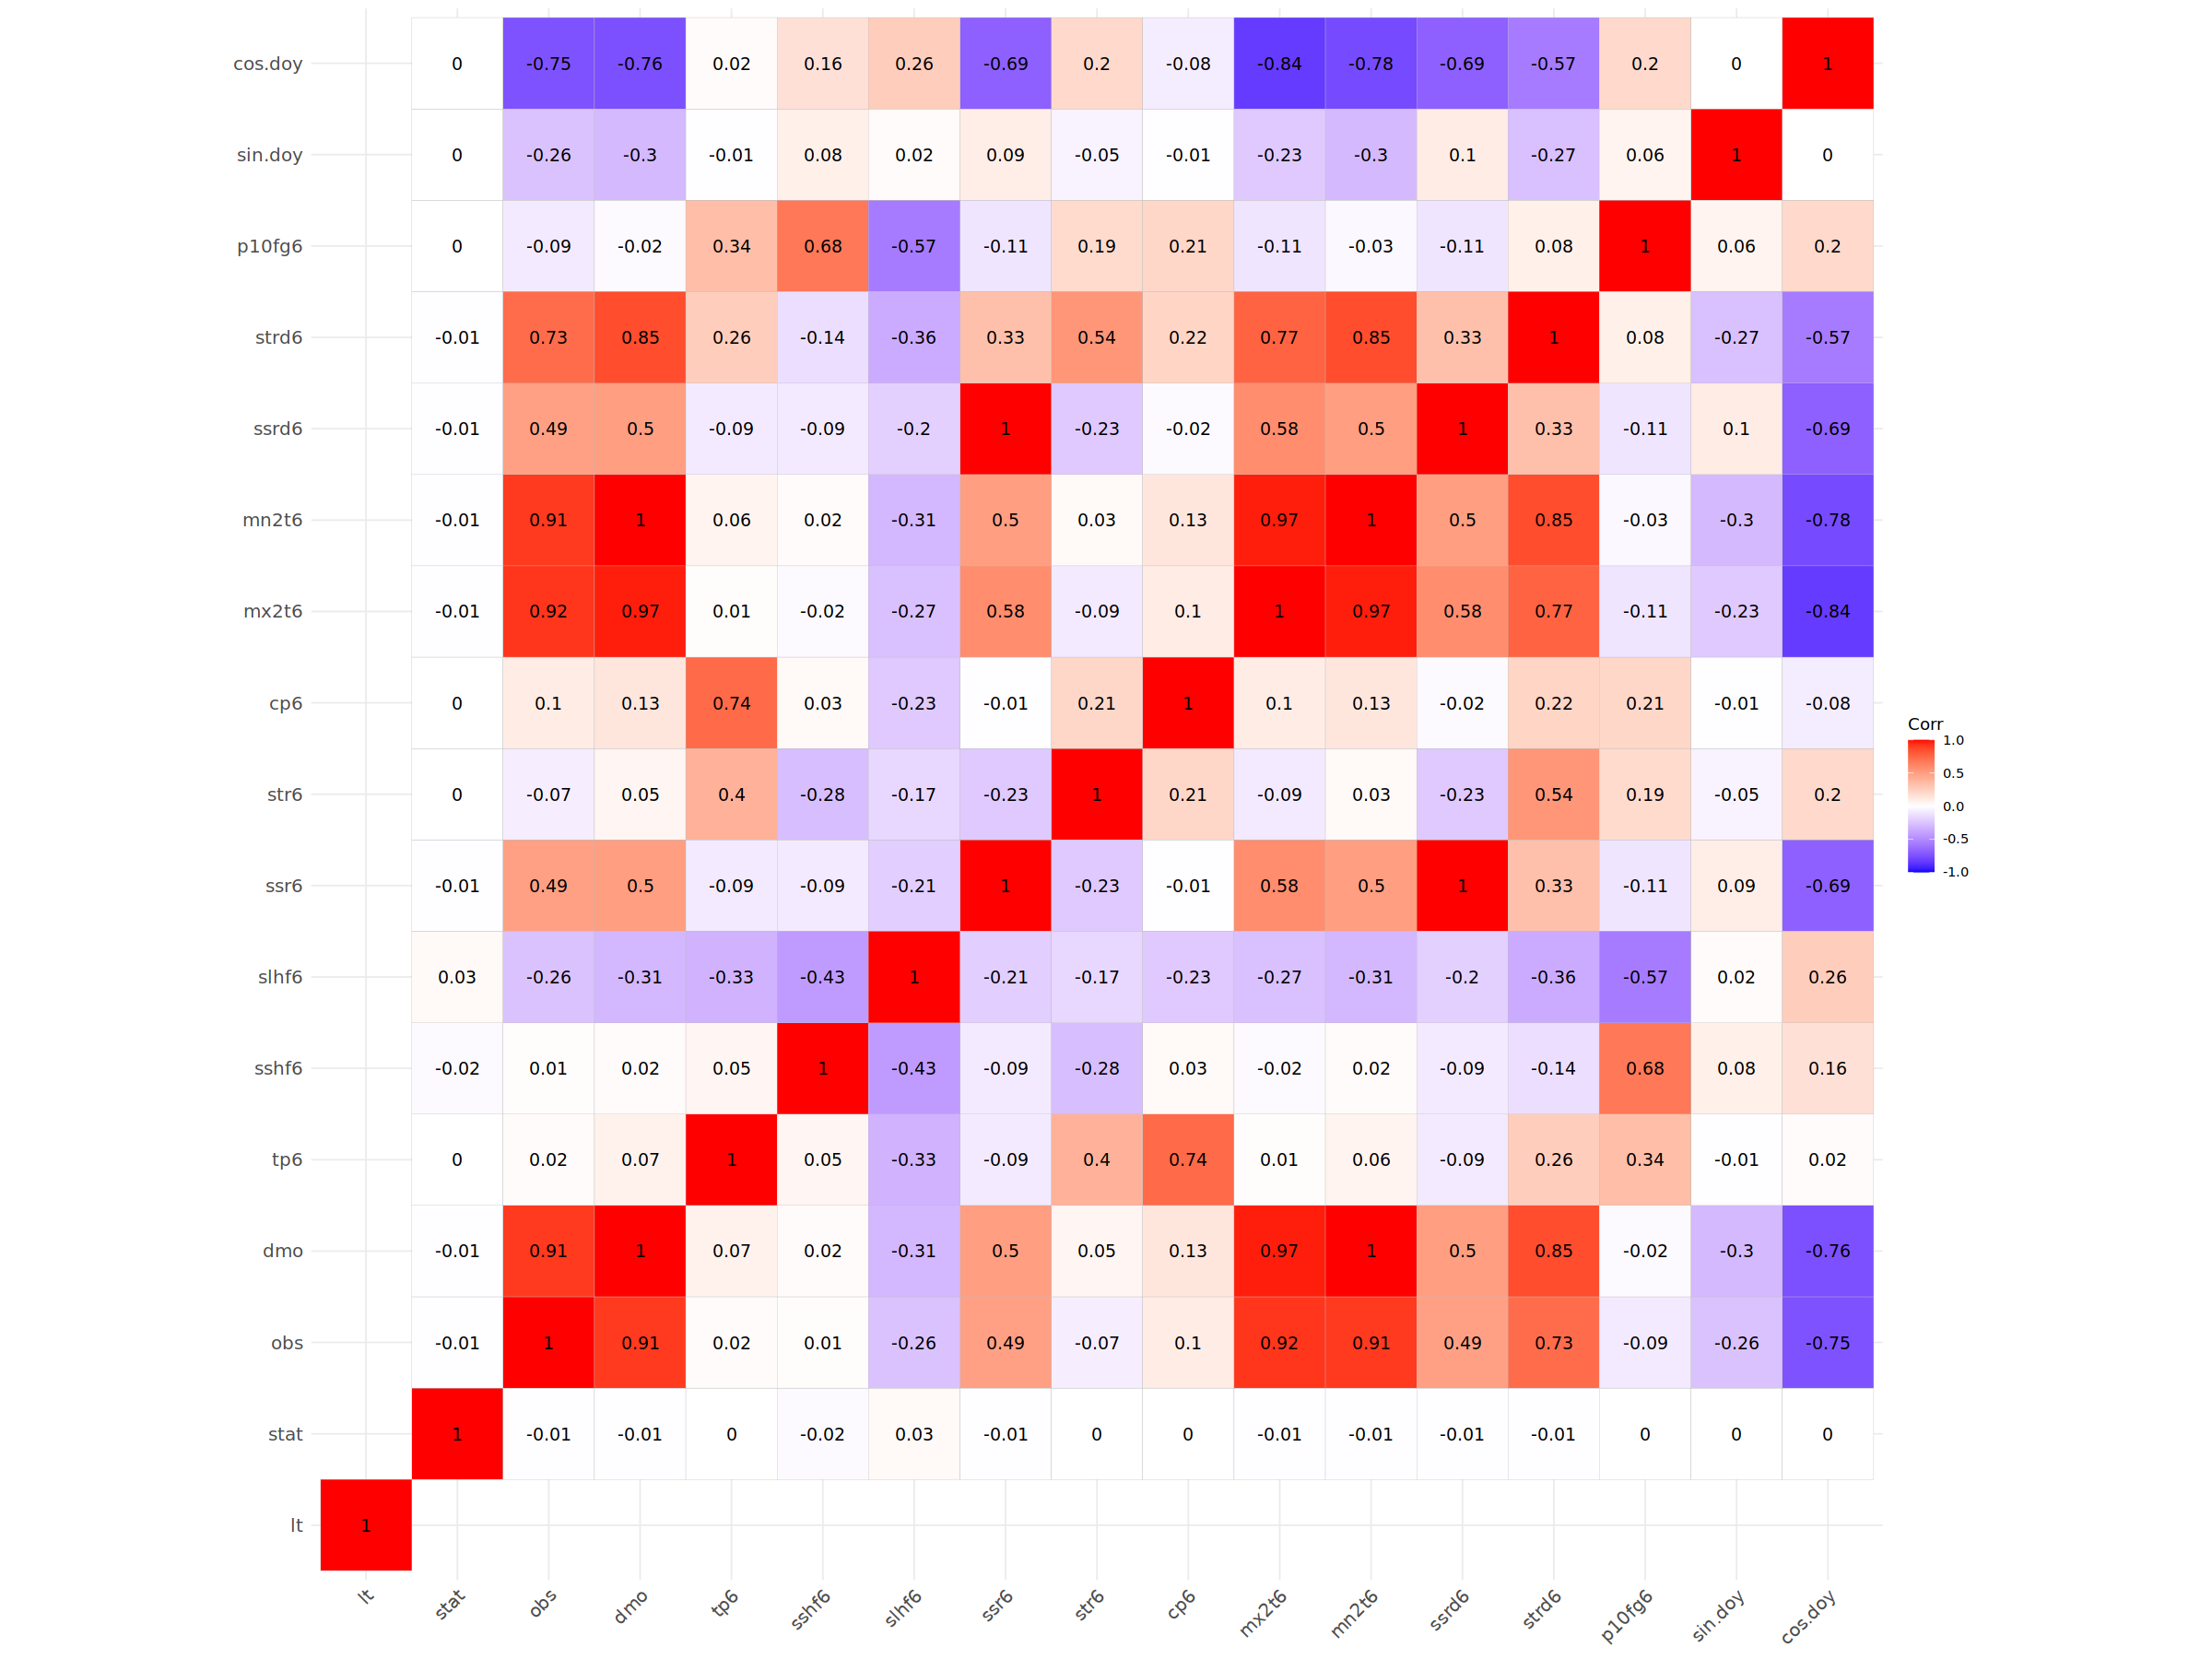

In [8]:
# Load the necessary libraries
library(ggcorrplot)

# Assuming your data is stored in a data frame named 'trai'
# Remove non-numeric columns (e.g., 'init', 'time', and 'stat' if they are not numeric)
trai_numeric <- trai_all[, sapply(trai_all, is.numeric)]

# Calculate the correlation matrix
cor_matrix <- cor(trai_numeric, use = "complete.obs")

# Adjust the size of the plotting window
options(repr.plot.width = 20, repr.plot.height = 15)  # Set width and height in inches

# Visualize the correlation matrix
ggcorrplot(cor_matrix, lab = TRUE)

**set up - one**

Top 5 correlated variables: dmo, mx2t6, mn2t6, strd6, cos.doy.

Here we use number of trees defined as 300, interaction.depth = 3, shrinkage = 0.1, bag.fraction = 0.7.

Only change for individual station is number of trees using gbm.per, and other hyperparameters remain same. We estimated other parameters using single station and hypertuning for worst performing station in linear model.


Forecast at Station: 460 (1 from 49)
[1] "Optimal number of trees for station 460: 116"
[1] "Relative Performance (GBM Model) for Station 460 : 0.376241253821489"
[1] "MSE (GBM Model) for Station 460 : 3.51697416225885"
[1] "MSE (DMO) for Station 460 : 5.63835647003872"
Forecast at Station: 662 (2 from 49)
[1] "Optimal number of trees for station 662: 72"
[1] "Relative Performance (GBM Model) for Station 662 : 0.221474343710308"
[1] "MSE (GBM Model) for Station 662 : 4.12209351009952"
[1] "MSE (DMO) for Station 662 : 5.29474330973837"
Forecast at Station: 691 (3 from 49)
[1] "Optimal number of trees for station 691: 65"
[1] "Relative Performance (GBM Model) for Station 691 : 0.163349144394315"
[1] "MSE (GBM Model) for Station 691 : 4.98190697179631"
[1] "MSE (DMO) for Station 691 : 5.95458301203757"
Forecast at Station: 704 (4 from 49)
[1] "Optimal number of trees for station 704: 74"
[1] "Relative Performance (GBM Model) for Station 704 : 0.0910841006067443"
[1] "MSE (GBM Model) for S

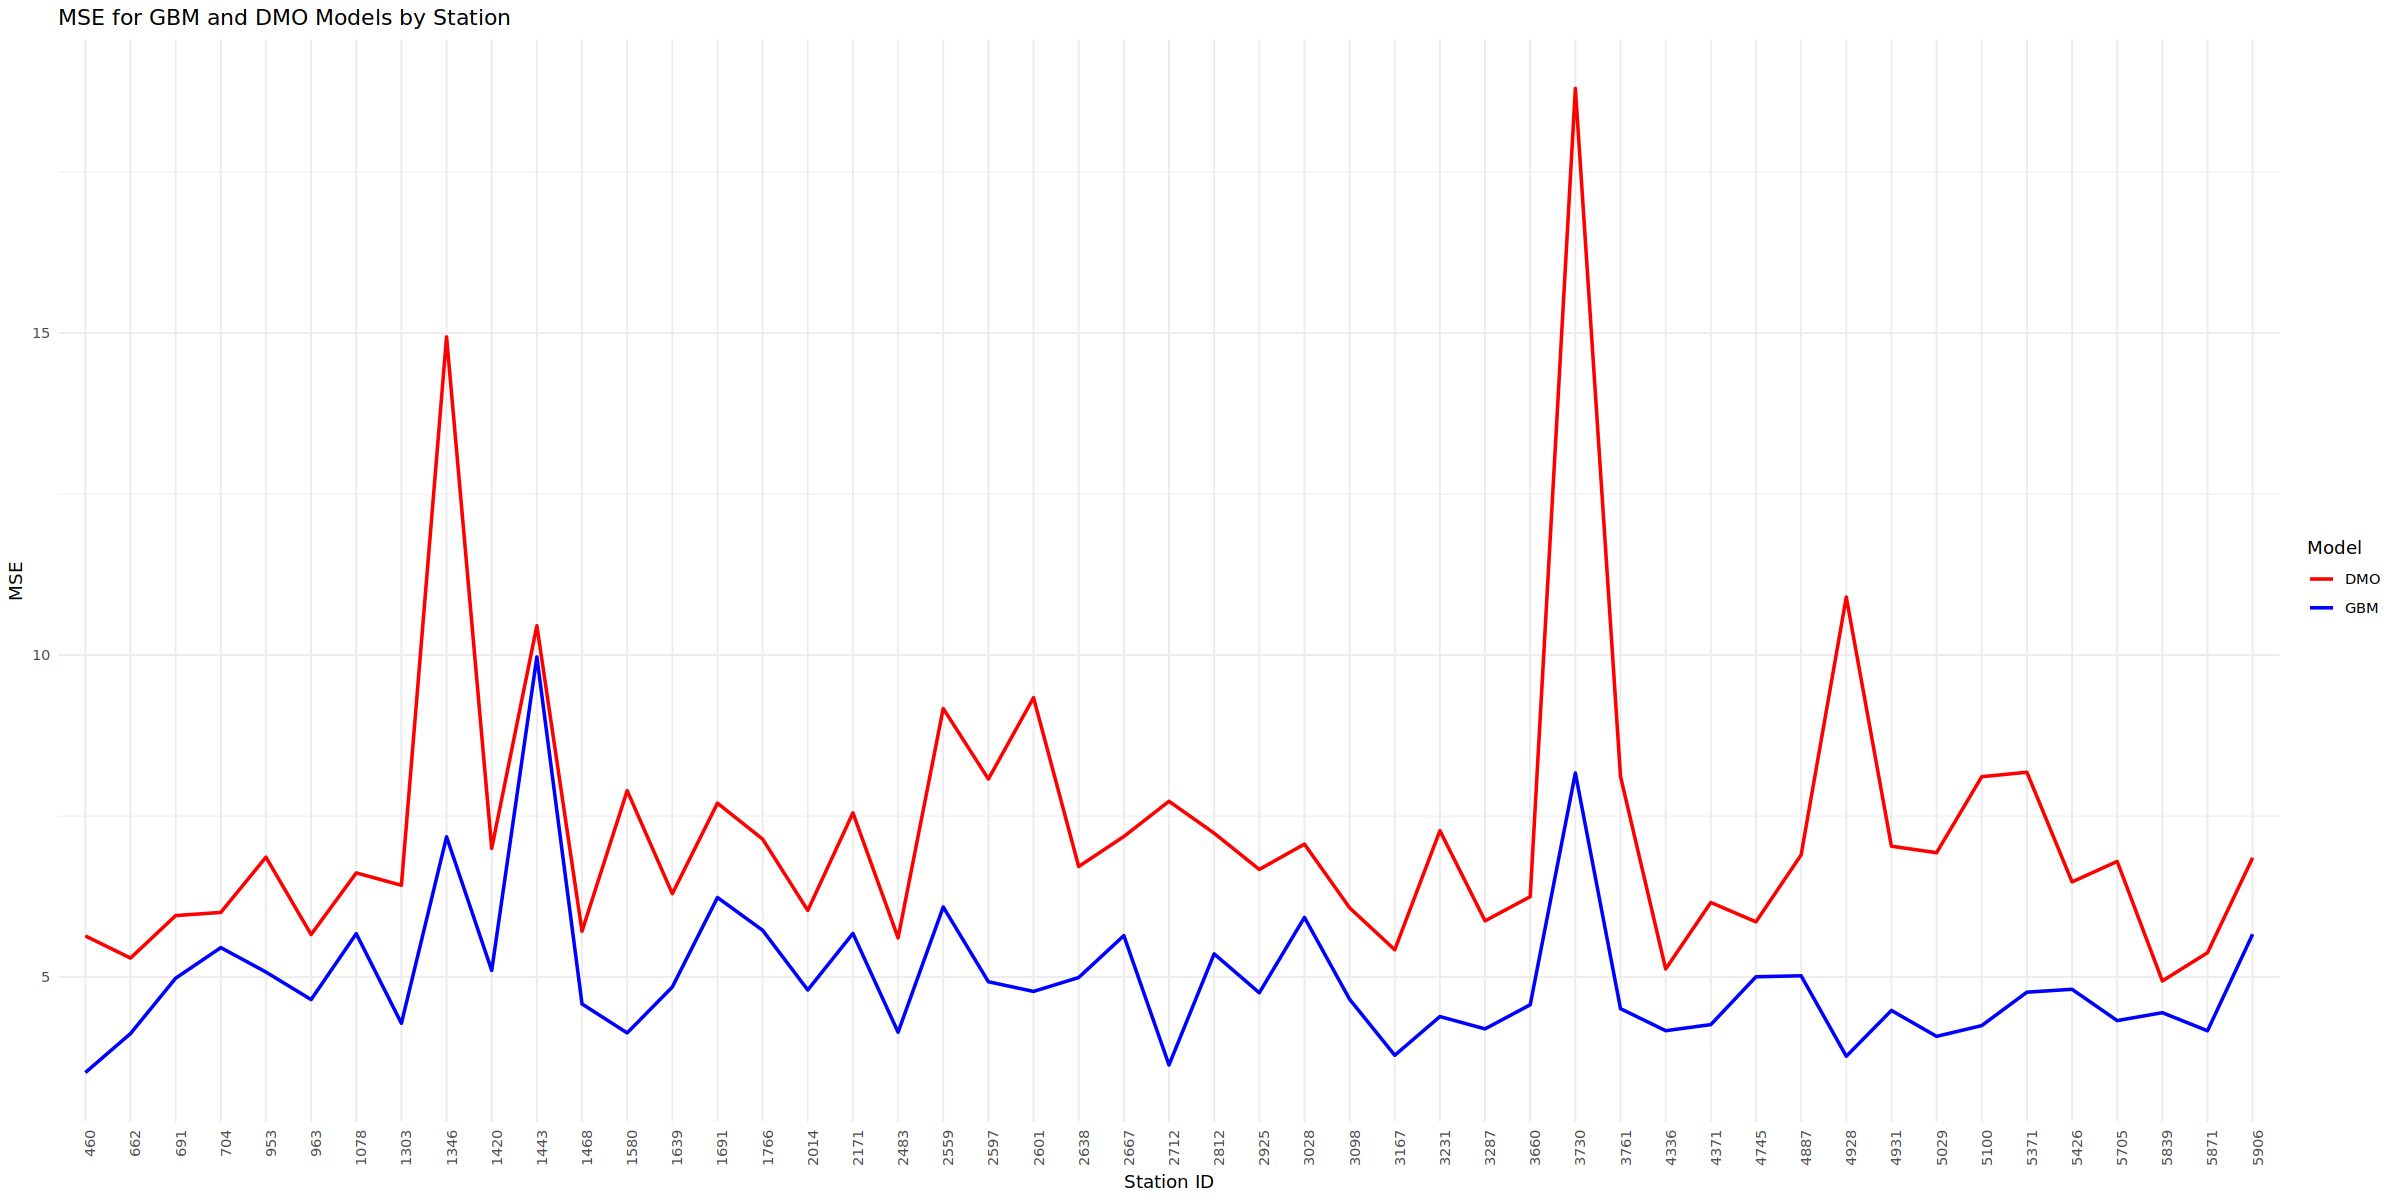

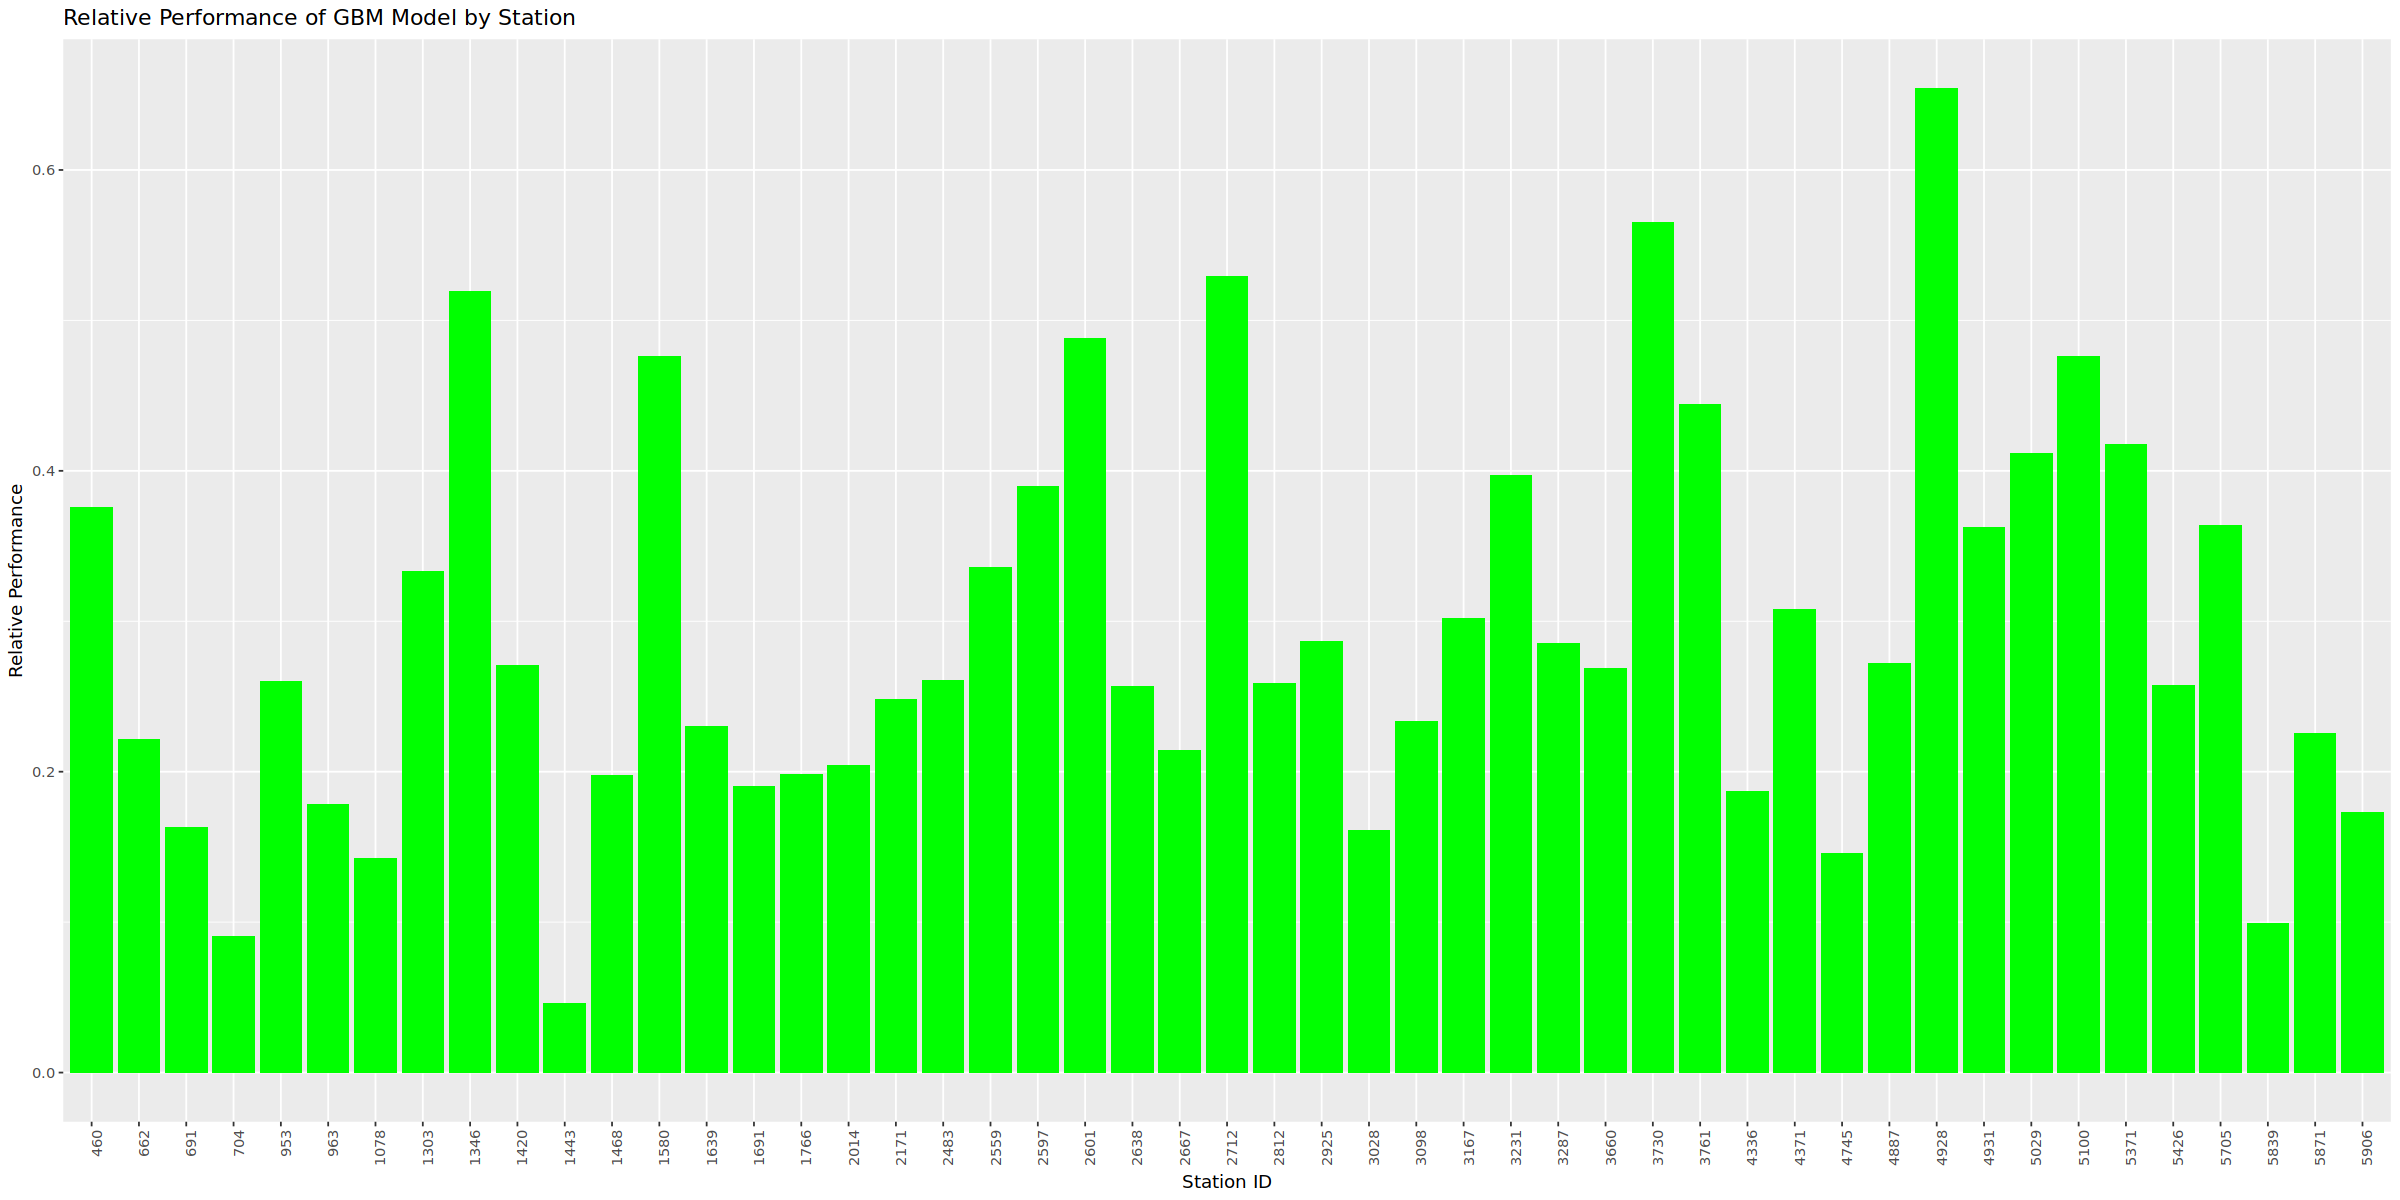

In [7]:
library(zoo)
library(gbm)

# Set a random seed for reproducibility
set.seed(123)

# Get unique station IDs
station_ids <- unique(fcs.test$latlon$station.id)
num_stations <- length(station_ids)


mse_gbm_values <- numeric(length(station_ids))
mse_dmo_values <- numeric(length(station_ids))
relative_performance_values <- numeric(length(station_ids))

# Initialize prediction matrix and observed/predicted value vectors
my.pred <- matrix(data = NA, nrow = length(fcs.test$time), ncol = num_stations)
observed_values <- numeric(0)
predicted_values <- numeric(0)

this_leadtime <- 120  # hours

# Loop over stations
for (st in station_ids) {
    
  cat(paste0('Forecast at Station: ', st, ' (', which(fcs.test$latlon$station.id == st), ' from ', num_stations, ')\n'))
  # Combine test data into one table
  idx.lt <- which(obs.test$leadtime == this_leadtime)
  idx.sta <- which(obs.test$latlon$station.id == st)
  obs <- obs.test$data$t2m[idx.lt, , idx.sta]
  time <- obs.test$time + this_leadtime * 3600   # leadtime is added to real time
  obs <- cbind(obs.test$time, this_leadtime, st, obs) # now obs at leadtime lt are combined with true time
  obs <- zoo(obs, time)
  colnames(obs) <- c('init', 'lt', 'stat', 'obs')

  idx.lt <- which(fcs.test$leadtime == this_leadtime)
  idx.sta <- which(fcs.test$latlon$station.id == st)
  dmo <- fcs.test$data$t2m[idx.lt, , idx.sta]

  # Extract other parameters from fcs.test$data
  tp6 <- fcs.test$data$tp6[idx.lt, , idx.sta]
  sshf6 <- fcs.test$data$sshf6[idx.lt, , idx.sta]
  slhf6 <- fcs.test$data$slhf6[idx.lt, , idx.sta]
  ssr6 <- fcs.test$data$ssr6[idx.lt, , idx.sta]
  str6 <- fcs.test$data$str6[idx.lt, , idx.sta]
  cp6 <- fcs.test$data$cp6[idx.lt, , idx.sta]
  mx2t6 <- fcs.test$data$mx2t6[idx.lt, , idx.sta]
  mn2t6 <- fcs.test$data$mn2t6[idx.lt, , idx.sta]
  ssrd6 <- fcs.test$data$ssrd6[idx.lt, , idx.sta]
  strd6 <- fcs.test$data$strd6[idx.lt, , idx.sta]
  p10fg6 <- fcs.test$data$p10fg6[idx.lt, , idx.sta]

  # Combine all parameters into the test data frame
  test <- cbind(dmo, tp6, sshf6, slhf6, ssr6, str6, cp6, mx2t6, mn2t6, ssrd6, strd6, p10fg6)
  time <- fcs.test$time + this_leadtime * 3600
  test <- zoo(test, time)
  test <- merge(obs, test)

  # Combine train data into one table
  trai.all <- NULL
  for (year in fcs.train$year) {
    idx.lt <- which(obs.train$leadtime == this_leadtime)
    idx.year <- which(obs.train$year == year)
    idx.sta <- which(obs.train$latlon$station.id == st)

    obs <- obs.train$data$t2m[idx.lt, idx.year, , idx.sta]
    year.dummy <- as.POSIXct(paste0(2017 - 20 + year, '-01-02'))
    time <- year.dummy + obs.train$time * 3600 * 24 + this_leadtime * 3600
    fctime_obs_trai <- year.dummy + obs.train$time * 3600 * 24
    obs <- cbind(fctime_obs_trai, this_leadtime, st, obs)
    obs <- zoo(obs, time)
    colnames(obs) <- c('init', 'lt', 'stat', 'obs')

    idx.lt <- which(fcs.train$leadtime == this_leadtime)
    idx.year <- which(fcs.train$year == year)
    idx.sta <- which(fcs.train$latlon$station.id == st)
    dmo <- fcs.train$data$t2m[idx.lt, idx.year, , idx.sta]

    tp6 <- fcs.train$data$tp6[idx.lt, idx.year, , idx.sta]
    sshf6 <- fcs.train$data$sshf6[idx.lt, idx.year, , idx.sta]
    slhf6 <- fcs.train$data$slhf6[idx.lt, idx.year, , idx.sta]
    ssr6 <- fcs.train$data$ssr6[idx.lt, idx.year, , idx.sta]
    str6 <- fcs.train$data$str6[idx.lt, idx.year, , idx.sta]
    cp6 <- fcs.train$data$cp6[idx.lt, idx.year, , idx.sta]
    mx2t6 <- fcs.train$data$mx2t6[idx.lt, idx.year, , idx.sta]
    mn2t6 <- fcs.train$data$mn2t6[idx.lt, idx.year, , idx.sta]
    ssrd6 <- fcs.train$data$ssrd6[idx.lt, idx.year, , idx.sta]
    strd6 <- fcs.train$data$strd6[idx.lt, idx.year, , idx.sta]
    p10fg6 <- fcs.train$data$p10fg6[idx.lt, idx.year, , idx.sta]

    trai <- cbind(dmo, tp6, sshf6, slhf6, ssr6, str6, cp6, mx2t6, mn2t6, ssrd6, strd6, p10fg6)
    time <- year.dummy + fcs.train$time * 3600 * 24 + this_leadtime * 3600

    trai <- zoo(trai, time)
    trai <- merge(obs, trai)

    trai.all <- rbind(trai.all, trai)
  }

  trai <- na.omit(trai.all)
  trai <- trai[which(index(trai) < as.POSIXct('2017-01-01')),]

  # Convert K to °C (run only once!)
  trai$obs <- trai$obs - 273.15
  test$obs <- test$obs - 273.15
  trai$dmo <- trai$dmo - 273.15
  test$dmo <- test$dmo - 273.15
  trai$mx2t6 <- trai$mx2t6 - 273.15
  test$mx2t6 <- test$mx2t6 - 273.15
  trai$mn2t6 <- trai$mn2t6 - 273.15
  test$mn2t6 <- test$mn2t6 - 273.15

  # Adding sine and cosine for day of the year to capture seasonality
  yday <- as.POSIXlt(index(trai))$yday
  trai$sin.doy <- sin(2 * pi * yday / 365)
  trai$cos.doy <- cos(2 * pi * yday / 365)

  yday <- as.POSIXlt(index(test))$yday
  test$sin.doy <- sin(2 * pi * yday / 365)
  test$cos.doy <- cos(2 * pi * yday / 365)

  # Train GBM model with cross-validation
  gbm_model <- gbm(
    formula = obs ~ dmo + mx2t6 + mn2t6 + str6 + slhf6,
    data = trai,
    distribution = "gaussian",  # assuming a regression task
    n.trees = 300,             # number of trees (boosting iterations)
    interaction.depth = 3,     # maximum depth of individual trees
    shrinkage = 0.1,           # learning rate (eta)
    bag.fraction = 0.7,        # fraction of data randomly sampled for each tree
    cv.folds = 10, n.cores = 64
  )

  # Determine the optimal number of trees using cross-validation
  best.n.tree <- gbm.perf(gbm_model, method = "cv", plot.it = FALSE)
  print(sprintf("Optimal number of trees for station %i: %i", st, best.n.tree))

  # Make predictions using the optimal number of trees
  pred <- predict(gbm_model, newdata = test, n.trees = best.n.tree)

  # Store predictions in the matrix
  my.pred[, which(station_ids == st)] <- pred
    
  mse.gbm <- mean((test$obs - pred)^2, na.rm = TRUE)
  mse.dmo <- mean((test$obs - test$dmo)^2, na.rm = TRUE)

  # Calculate relative performance of GBM model compared to DMO
  relative_performance_gbm <- 1 - mse.gbm / mse.dmo

  # Print results for each station
  print(paste("Relative Performance (GBM Model) for Station", st, ":", relative_performance_gbm))
  print(paste("MSE (GBM Model) for Station", st, ":", mse.gbm))
  print(paste("MSE (DMO) for Station", st, ":", mse.dmo))  
    

  

  observed_values <- c(observed_values, test$obs)
  predicted_values <- c(predicted_values, pred)
    
    
  # Store MSE and relative performance
  station_index <- which(station_ids == st)
  mse_gbm_values[station_index] <- mse.gbm
  mse_dmo_values[station_index] <- mse.dmo
  relative_performance_values[station_index] <- relative_performance_gbm 
    
}

saveRDS(my.pred, file = "my.GBM.MOS_group_X1_test.rds")

# Overall performance
na_indices <- which(!is.na(observed_values) & !is.na(predicted_values))
observed_values <- observed_values[na_indices]
predicted_values <- predicted_values[na_indices]

overall_r_squared <- cor(observed_values, predicted_values)^2
overall_rmse <- sqrt(mean((observed_values - predicted_values)^2))
overall_mse <- mean((observed_values - predicted_values)^2)

# Print overall metrics
print(paste("Overall R-squared:", overall_r_squared))
print(paste("Overall RMSE:", overall_rmse))
print(paste("Overall MSE:", overall_mse))


# Create a data frame for plotting
plot_data <- data.frame(
  StationID = as.factor(station_ids),
  MSE_GBM = mse_gbm_values,
  MSE_DMO = mse_dmo_values,
  RelativePerformance = relative_performance_values
)

# Line plot for MSE comparison
mse_plot <- ggplot(plot_data, aes(x = StationID)) +
  geom_line(aes(y = MSE_GBM, color = "GBM", group = 1), size = 1) +
  geom_line(aes(y = MSE_DMO, color = "DMO", group = 1), size = 1) +
  labs(title = "MSE for GBM and DMO Models by Station", y = "MSE", x = "Station ID") +
  scale_color_manual(name = "Model", values = c("GBM" = "blue", "DMO" = "red")) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))

# Set plot size using options
options(repr.plot.width = 20, repr.plot.height = 10)



# Print the MSE plot
print(mse_plot)





# Relative performance plot
relative_performance_plot <- ggplot(plot_data, aes(x = StationID, y = RelativePerformance)) +
  geom_bar(stat = "identity", fill = "green") +
  labs(title = "Relative Performance of GBM Model by Station", y = "Relative Performance", x = "Station ID") +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))



print(relative_performance_plot)



